<a href="https://colab.research.google.com/github/ammobam/AIcow/blob/main/HJ_ai_hub_cow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 공통 코드
# 파이썬 >= 3.5 필수
import sys
assert sys.version_info >= (3,5)

# 사이킷런 >= 0.20 필수
import sklearn
assert sklearn.__version__ >="0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import seaborn as sns
import os

# 시드 설정
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 음수 출력
mpl.rcParams['axes.unicode_minus'] = False

# 폰트 설정
import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
	rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

# 그림 저장 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "DeepLearning_Keras_CNN" ##
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 경고 없애기
import warnings
warnings.filterwarnings(action='ignore')

# 텐서플로와 케라스
import tensorflow as tf
from tensorflow import keras

# json 파싱
import json
# 텐서플로우 데이터셋
import tensorflow_datasets as tfds

# 가축 이미지 객체탐지 및 키포인트 추출
* 데이터 : AI hub에 있는 가축 이미지 키포인트를 추출해보자
* train 원천 이미지를 불러와서 라벨 json 파일의 키포인트를 그려보자
* 위를 CNN 학습하자
* valid 원천 이미지에 학습한 모델을 적용하여 키포인트를 추출해보자
* valid 라벨을 불러와서 모델이 정확히 동작했는지 확인해보자

## 데이터 불러오기
* 폴더 경로
* datasets
* ┗ cow
* ┗ 가축 행동 영상　┳ Training ┳ [원천]소_keypoints
*　　　　　　　　　┃　　　　　┣ [라벨]소_keypoints
*　　　　　　　　　┃　　　　　┣ [원천]소_bbox
*　　　　　　　　　┃　　　　　┗ [라벨]소_bbox
*　　　　　　　　　┗ Validation　┳ [원천]소_keypoints
*　　　　　　　　　　　　　　　　┣ [라벨]소_keypoints
*　　　　　　　　　　　　　　　　┣ [원천]소_bbox
*　　　　　　　　　　　　　　　　┗ [라벨]소_bbox




In [ ]:
# 데이터 경로 생성
train_source_key_path = 'datasets/cow/가축 행동 영상/Training/[원천]소_keypoints'
train_label_key_path = 'datasets/cow/가축 행동 영상/Training/[라벨]소_keypoints'
train_source_box_path = 'datasets/cow/가축 행동 영상/Training/[원천]소_bbox'
train_label_box_path = 'datasets/cow/가축 행동 영상/Training/[라벨]소_bbox'

valid_source_key_path = 'datasets/cow/가축 행동 영상/Validation/[원천]소_keypoints'
valid_label_key_path = 'datasets/cow/가축 행동 영상/Validation/[라벨]소_keypoints'
valid_source_box_path = 'datasets/cow/가축 행동 영상/Validation/[원천]소_bbox'
valid_label_box_path = 'datasets/cow/가축 행동 영상/Validation/[라벨]소_bbox'

In [ ]:
# 경로 + 파일명 리스트 만들기
import os

def file_dir(path):
    # 입력받은 경로에 있는 파일명 리스트 만들기
    file_name_list = os.listdir(path)
    # 파일 개수
    len_list = len(file_name_list)
    
    # 경로 + 파일명 리스트 만들기
    path_list = []
    for idx in range(len_list):
        a = path + '/' + file_name_list[idx]
        path_list.append(a)
    return path_list

In [ ]:
# 확인
train_source_key_path = file_dir(train_source_key_path)
train_label_key_path = file_dir(train_label_key_path)

## 이미지 출력

In [ ]:
# 이미지 출력 방법 1
from PIL import Image
image = Image.open(train_source_key_path[0])
print(type(image))
#image.show()

<class 'numpy.ndarray'>
(86, 194, 3)


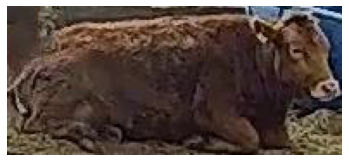

In [ ]:
# 이미지 출력 2
import matplotlib.image as img
import matplotlib.pyplot as plt

ndarray=img.imread(train_source_key_path[0])
plt.imshow(ndarray)
plt.axis('off')

print(type(ndarray))
print(ndarray.shape)

In [ ]:
# 이미지 출력 함수
import matplotlib.image as img
import matplotlib.pyplot as plt

def draw_cow(path):
    #len_list = len(path)
    len_list =15
    plt.figure(figsize=(16, 8))

    for idx in range(len_list):
        #print(img.imread(path[idx]).shape)
        plt.subplot(3, 5, idx+1)
        plt.imshow(img.imread(path[idx]))
        #plt.plot(img.imread(path[idx]))
        plt.axis('off')

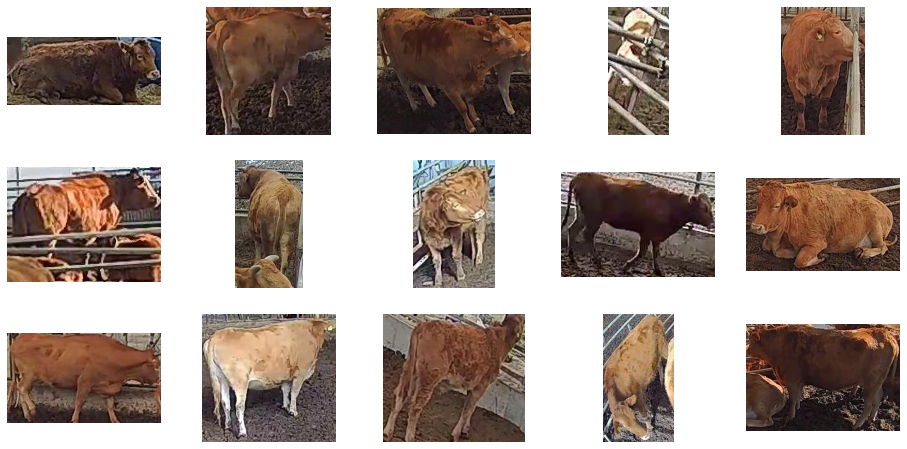

In [ ]:
# 확인
draw_cow(train_source_key_path)

## ■ 할 것 : 소 이미지 전처리 필요
* 이미지 사이즈 균일하게 맞추기
* 모델 개선할 때 이미지 증강도 해보자

## 키포인트 라벨 출력
* json 파일을 읽어오자
* 파일에서 키포인트 좌표를 읽어오자
* 키포인트 좌표를 이미지 위에 그려보자

* json 파일 내용 :
![image.png](attachment:image.png)

In [ ]:
# json 파일 내용 확인하기
# 참고 https://lapina.tistory.com/69
import json
from pprint import pprint
with open(train_label_key_path[0]) as data_file:
    local = json.load(data_file)
pprint(local)

{'label_info': {'annotations': [{'bbox': [0, 0, 194, 86],
                                 'category_id': 2,
                                 'keypoints': [168,
                                               9,
                                               2,
                                               147,
                                               11,
                                               2,
                                               115,
                                               10,
                                               2,
                                               120,
                                               60,
                                               2,
                                               141,
                                               77,
                                               2,
                                               112,
                                               78,
                        

In [ ]:
train_label_key_path[0]

'datasets/cow/가축 행동 영상/Training/[라벨]소_keypoints/livestock_cow_keypoints_000001.json'

In [ ]:
# json 파일에 있는 정보 읽어오기
# 방법1: pandas.read_json을 사용
# 방법2: eval 사용해서 값 꺼내기
import pandas as pd
key_label_df = pd.read_json(train_label_key_path[0])
#key_label_df.index

pandas.core.frame.DataFrame

In [ ]:
# 'annotations', 'categories', 'image'
key_label_df_T = key_label_df.transpose()
train_annotations = key_label_df_T['annotations'] # Series

In [ ]:
# index
key_label_df.label_info.index

In [ ]:
key_label_df.label_info.annotations

In [ ]:
key_label_df.label_info.categories

In [ ]:
key_label_df.label_info.image
# type(key_label_df.label_info.image) # dict. key-value를 꺼내써보자

In [ ]:
# file_name의 값에 해당하는 이미지에 keypoints 그려보자
file_name = key_label_df.label_info.image['file_name']

In [ ]:
# keypoints를 꺼내보자
[annotations] = key_label_df.label_info.annotations
annotations # dict
annotations['keypoints']
# len(annotations['keypoints'])   # 51

In [ ]:
# 각 키포인트를 따로 저장하자
# x좌표, y좌표, vis 여부
keypoints_list = annotations['keypoints']
keypoints_num = len(keypoints_list)

cow_key_x = []
cow_key_y = []
cow_key_vis = []
for idx in range(keypoints_num):
    if idx % 3 == 0:
            cow_key_x.append(keypoints_list[idx])
    elif idx % 3 == 1:
            cow_key_y.append(keypoints_list[idx])
    else :
            cow_key_vis.append(keypoints_list[idx])

In [ ]:
# 이제 x, y 좌표로 소 사진 위에 키포인트 찍어보자
cow_key_x[i], cow_key_y[i]